##  Data Wrangling<a id='1_Data_Wrangling'></a>

## 1.1 Contents<a id='1.1_Contents'></a>

* [1 Data wrangling](#1_Data_Wrangling)
  * [1.1 Contents](#1.1_Contents)
  * [1.2 Introduction](#1.2_Introduction)
  * [1.3 Objectives](#1.3_Objectives)
  * [1.4 Imports](#1.4_Imports)
  * [1.5 Bird Species](#1.5_Bird_Data)
  * [1.6 Explore The Data](#1.6_EDA)
    * [1.6.1 Dropping Columns](#1.6.1_Dropping_Columns)
    * [1.6.2 Drop Rows With No Price Data](#1.6.2_Drop_Rows_With_No_Price_Data)
    * [1.6.3 Anomalies](#1.6.3_Anomalies)
    * [1.6.4 Number Of Missing Values By Column](#1.6.4_Number_Of_Missing_Values_By_Column)
    * [1.6.5 Relabeling of Columns](#1.6.5_Relabel_Columns)
      * [1.6.5.1 Fixing Datatypes of Columns](#1.6.5.1_Fixing_Datatypes_of_columns)
      * [1.6.5.2 Reverse Geolocator](#1.6.5.2_Reverse_Geolocator)
    * [1.6.6 Distribution](#1.6.6_Distribution)
      * [1.6.6.1 Number of distinct neighborhoods](#1.6.6.1_Number_of_distinct_neighborhoods)
      * [1.6.6.2 Distribution Of Housing Price By Borough](#1.6.6.2_Distribution_Of_Housing_Price_By_Borough)
  * [1.7 Neighborhood Statistics](#1.7_Neighborhood_Statistics)
  * [1.8 Save data](#1.8_Save_data)
  * [1.9 Summary](#1.9_Summary)

## 1.2 Introduction<a id='1.2_Introduction and Problem'></a>

Numan Bird Watch is an international organization of bird conservation and exploration of new species of birds. They are currently building a large database of images in different species of birds and have tasked me to properly create a model which identifies different species. They have great explorer who take high quality images of birds across the globe, but the explorer cannot always properly identify which bird they have taken a photo off. I am tasked with creating a robust model which can classify 315 different species with high accuracy.

## 1.3 Objectives<a id='1.3_Objectives'></a>

The dataset us with over 49k birds of 315 species, all being 224 X 224 X 3 color images in JPG format. With such high quality images we will be able to try various methods to come up with the best results such as CNN(Convolutional neural network) to process all pixel data, utilize transfer learning and pre-trained models in-order to compare and contrast results from our models.

I will look to provide in-depth analysis of different facets of image classification, feature extraction and comparing results of my sand-box models to pre-trained models from larger datasets and ultimately to achieve the best results possible in properly classifying each bird species. 

## 1.4 Imports<a id='1.4_Imports'></a>

In [1]:
import pandas as pd
import seaborn as sns
import statistics as stat
import numpy as np
import matplotlib.pyplot as plt
import glob
from os import listdir
from os.path import isfile, join
from PIL import Image
import bpy
import random
import cv2
from collections import Counter
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Activation, Dropout
from keras.utils.vis_utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import load_model
from skimage import color
import keras
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.model_selection import RandomizedSearchCV

## 1.5 Bird Species<a id='1.5_Bird_Data'></a>

In [4]:
species = []
#Lets get all the labels of the bird species since the dataset is has been made simply for us to use,
# all the data is already split into train, test, and valid so we don't need to split and they each contain
# the same amount of labels being the 315 different bird species.  ""
filepath = "C:/Users/izine/Desktop/GitHub/Springboard-Data-Science/Capstone 3/birds/"
labelpath = "C:/Users/izine/Desktop/GitHub/Springboard-Data-Science/Capstone 3/birds/test"
for label in listdir(labelpath):
    species.append(label)
# The first 10 species
species[:10]

['AFRICAN CROWNED CRANE',
 'AFRICAN FIREFINCH',
 'ALBATROSS',
 'ALEXANDRINE PARAKEET',
 'AMERICAN AVOCET',
 'AMERICAN BITTERN',
 'AMERICAN COOT',
 'AMERICAN GOLDFINCH',
 'AMERICAN KESTREL',
 'AMERICAN PIPIT']

In [5]:
listdir('C:/Users/izine/Desktop/GitHub/Springboard-Data-Science/Capstone 3/birds/valid/AFRICAN CROWNED CRANE')

['1.jpg', '2.jpg', '3.jpg', '4.jpg', '5.jpg']

### Since this is a image dataset there isn't much data cleaning to be down, for analysis purposes I will show how all the images are not corrupted.

In [6]:
# for ds in ["train", "test", "valid"]:
#     for s in species:
#         for filename in listdir(filepath + ds + '/' + s):
#             if filename.endswith('.jpg'):
#                 try:
#                     img = Image.open('./'+filename) # open the image file
#                     img.verify() # verify that it is, in fact an image
#                 except (IOError, SyntaxError) as e:
#                     print('Bad file:', filename) # print out the names of corrupt files
# I have tried to check for corrupt images but my code either detects all the images to be corrupt or none further research
# is necessary for now take my word there are no corrupte images

### Loading the dataset

In [7]:
%%time
# To see how long it takes to run

# To assign upload and assign each image to their corresponding dataset i.e train, test and valid, we will make a dict 
# with lists to hold the images 
images = {"train": [], "test": [], "valid": []}
labels = {"train": [], "test": [], "valid": []}

for ds in ["train", "test", "valid"]:
    for s in species:
        filelist = glob.glob(filepath + ds + '/' + s + '/*.jpg')
        labels[ds].extend([s for l in filelist])
        images[ds].extend([np.array(Image.open(fname)) for fname in filelist])
    images[ds] = np.stack(images[ds], axis=0)

Wall time: 2min 13s


In [7]:
# Let's check out the shapes of our dataset 
print('Train shape: ' + str(images['train'].shape))
print("Test shape: " + str(images["test"].shape))
print("Valid shape: " + str(images["valid"].shape))

# Let's check our label groups as well 
print("Number of Species are: " + str(len(species)))

Train shape: (45980, 224, 224, 3)
Test shape: (1575, 224, 224, 3)
Valid shape: (1575, 224, 224, 3)
Number of Species are: 315


In [8]:
print(type(images['train']))
print(type(labels['train']))

<class 'numpy.ndarray'>
<class 'list'>


In [9]:
# For better calculations and proccessing and memory usage lets convert all this to numpy arrays
# And we can do this for both the images and their labels. 
for k in list(labels):
    labels[k] = np.array(labels[k])


In [10]:
# Check the type
print(type(images['train']))
print(type(labels['train']))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


### Let's view some of the images from the training dataset

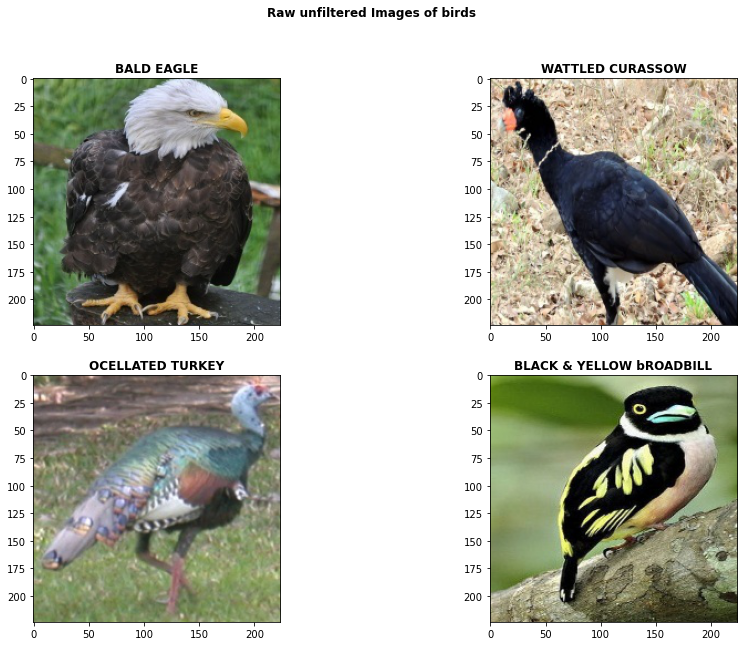

In [11]:
fig = plt.figure(figsize=(15,10))

row = 2
col = 2
fig.suptitle("Raw unfiltered Images of birds", weight='bold')
for i in range(1,5):
    img = random.randint(0, images["train"].shape[0])
    ax = fig.add_subplot(row, col, i)
    ax.set_title(labels["train"][img], fontdict={"fontweight": 700})
    ax.imshow(images["train"][img])
    

In the same fashion we can also convert these images to grayscale, while this might not seem useful now but we can test to see later down the pipeline if grayscaling these images help with better classfication

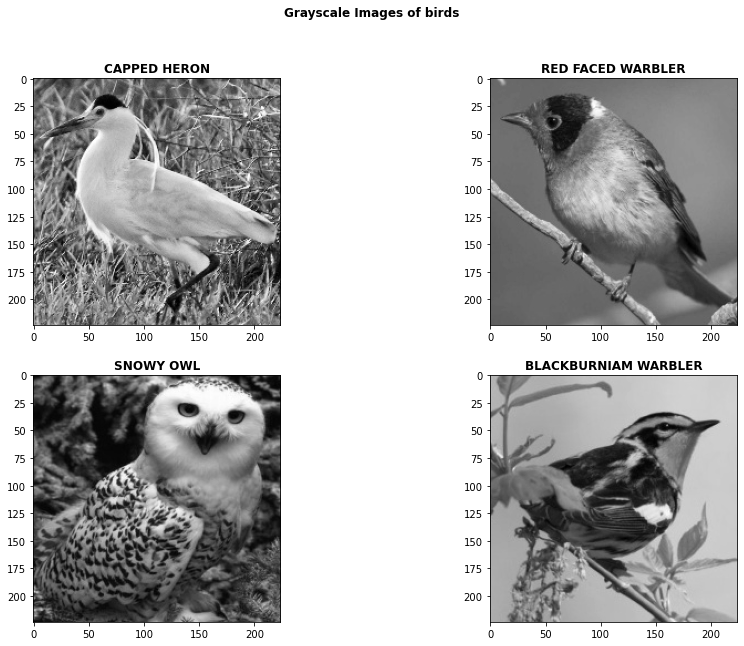

In [12]:
fig = plt.figure(figsize=(15,10))

row = 2
col = 2
fig.suptitle("Grayscale Images of birds", weight='bold')
for i in range(1,5):
    img = random.randint(0, images["train"].shape[0])
    ax = fig.add_subplot(row, col, i)
    ax.set_title(labels["train"][img], fontdict={"fontweight": 700})
    ax.imshow(color.rgb2gray(images["train"][img]),  cmap="gray")



## 1.6 Explore The Data<a id='1.6_EDA'></a>

In [13]:
# Let's view the distribution of different species and how many are in each datplt.ase
# First we take our data from the labels giving us each species and we get a value_count for those species
# afterwards we turn it into a dataframe so we can easily manipulate and create graphs 
# initially this took more steps to manufracture what you see is the cleaner version compared to past trials. 
train_b_count = pd.DataFrame(pd.DataFrame({"Species" : np.array(labels['train'])}).value_counts()).reset_index()

test_b_count = pd.DataFrame(pd.DataFrame({"Species" : np.array(labels['test'])}).value_counts()).reset_index()

valid_b_count = pd.DataFrame(pd.DataFrame({"Species" : np.array(labels['valid'])}).value_counts()).reset_index()

In [14]:
# Rather than viewing different dataframes for occurences we can merge all three into one which is being done below
total_b_count = train_b_count.merge(test_b_count,on='Species').merge(valid_b_count,on='Species')
total_b_count.columns = ['Species', 'Train', 'Test', 'Valid']

#### Check for any duplicates 

In [15]:
total_b_count[total_b_count['Species'].duplicated()]
# Good this is how we know we didnt mess up any transformation and all species are unique

,Species,Train,Test,Valid


In [16]:
# Let's view the top 10 bird species in terms of data images available. 
total_b_count.head(10)

,Species,Train,Test,Valid
0,HOUSE FINCH,249,5,5
1,D-ARNAUDS BARBET,233,5,5
2,OVENBIRD,233,5,5
3,SWINHOES PHEASANT,217,5,5
4,WOOD DUCK,214,5,5
5,CASPIAN TERN,213,5,5
6,OYSTER CATCHER,207,5,5
7,DARK EYED JUNCO,203,5,5
8,RED TAILED HAWK,202,5,5
9,VIOLET GREEN SWALLOW,201,5,5


In [17]:
total_b_count.tail(1)

,Species,Train,Test,Valid
314,BLACK SWAN,119,5,5


In [18]:
# We can see further statistics for our data set via .describe()
total_b_count.describe()

,Train,Test,Valid
count,315.000000,315.0,315.0
mean,145.968254,5.0,5.0
std,23.762873,0.0,0.0
min,119.000000,5.0,5.0
25%,127.500000,5.0,5.0
50%,141.000000,5.0,5.0
75%,159.000000,5.0,5.0
max,249.000000,5.0,5.0


We can see that all dataset contain 315 different unique Species and each specie has 5 photo in test and valid set whereas in the Train set it varies. The most abundant specie we have is House Finch with 249 photos and the least is Black Swan with 119 in our training set. Let's try to find some insights into which type of birds appear the most in this dataset utilizing wordcloud, we are looking for perphaps a specific family, or color, and wordcloud will show us the most repeated words. 

In [19]:
# First we take in a list of all species names and put into a single string which can later feed into our wordcloud generator
wstring = " ".join(total_b_count.Species.tolist())

In [20]:
wordcloud = WordCloud(max_font_size=100, max_words=30, background_color="white").generate(wstring)

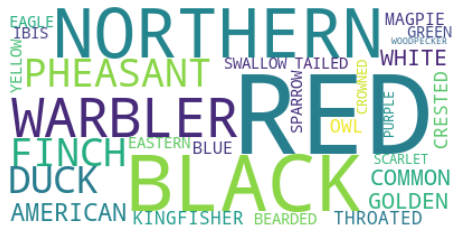

In [21]:
plt.figure(figsize=(8,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

It's important to point out that this has no correlation to the number of images of each bird has, as these are all the unique specie names in the dataset, we can see there are a lot of birds from the family of Finch, Pheasant, Warbler and we can also see many birds are from the region of America. 

#### Let's plot some of the species distributions

In [22]:
total_b_count.head(10)['Train'].to_list()

[249, 233, 233, 217, 214, 213, 207, 203, 202, 201]

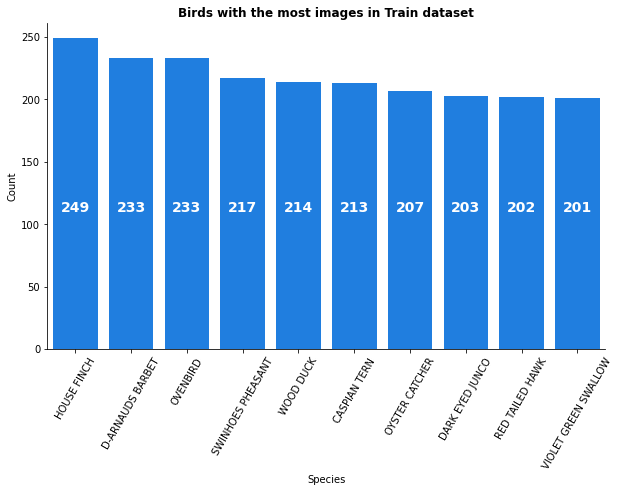

In [23]:
fig, ax = plt.subplots(figsize=(10,6))
count = total_b_count.head(10)['Train'].to_list()
sns.barplot(x='Species', y='Train', data=total_b_count.head(10), color='#007dff')
ax.set(ylabel = 'Count')
plt.title('Birds with the most images in Train dataset', fontweight='bold')
plt.xticks(rotation=60)
for i, j in enumerate(count):
    ax.text(i , 110, f'{j}', ha='center', fontsize=14, weight='bold', color='white')
sns.despine()

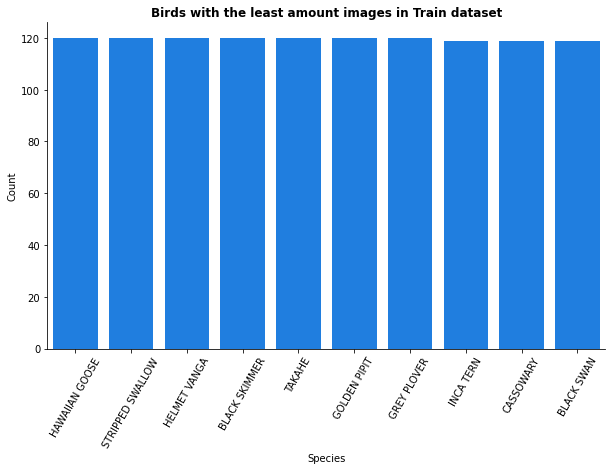

In [24]:
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(x='Species', y='Train', data=total_b_count.tail(10), color='#007dff')
ax.set(ylabel = 'Count')
plt.title('Birds with the least amount images in Train dataset', fontweight='bold')
plt.xticks(rotation=60)
sns.despine()

Its good to see that the minimum number of photos we have is 120, this will suffice to avoid underfitting, while I could plot the number of images for each species it would be insanely large and hard to read

We can also look at for which channel of color is most prevalent in our dataset as well

#### DO not run load the files below

In [110]:
%%time

rgb_data = []

for s in species:
    filelist = glob.glob(filepath + 'train' + '/' + s + '/*.jpg')
    avgRGB = []
    for f in filelist:
        img = Image.open(f)
        pv = np.array(img.getdata())
        RGB = np.round(np.mean(pv, axis=0))
        avgRGB.append(RGB)
    avgRGB = np.array(avgRGB)
    s_ARGB = np.round(np.mean(avgRGB, axis=0))
    rgb_data.append([s, int(s_ARGB[0]), int(s_ARGB[1]), int(s_ARGB[2])])

Wall time: 26min 39s


In [ ]:
rgb_train_df = pd.DataFrame(rgb_data, columns = ['Species', 'Red', 'Green', 'Blue'])

In [ ]:
rgb_train_df.head()

In [141]:
%%time

rgb_data = []

for s in species:
    filelist = glob.glob(filepath + 'test' + '/' + s + '/*.jpg')
    avgRGB = []
    for f in filelist:
        img = Image.open(f)
        pv = np.array(img.getdata())
        RGB = np.round(np.mean(pv, axis=0))
        avgRGB.append(RGB)
    avgRGB = np.array(avgRGB)
    s_ARGB = np.round(np.mean(avgRGB, axis=0))
    rgb_data.append([s, int(s_ARGB[0]), int(s_ARGB[1]), int(s_ARGB[2])])


rgb_test_df = pd.DataFrame(rgb_data, columns = ['Species', 'Red', 'Green', 'Blue'])

Wall time: 48.4 s


In [142]:
%%time

rgb_data = []

for s in species:
    filelist = glob.glob(filepath + 'valid' + '/' + s + '/*.jpg')
    avgRGB = []
    for f in filelist:
        img = Image.open(f)
        pv = np.array(img.getdata())
        RGB = np.round(np.mean(pv, axis=0))
        avgRGB.append(RGB)
    avgRGB = np.array(avgRGB)
    s_ARGB = np.round(np.mean(avgRGB, axis=0))
    rgb_data.append([s, int(s_ARGB[0]), int(s_ARGB[1]), int(s_ARGB[2])])


rgb_valid_df = pd.DataFrame(rgb_data, columns = ['Species', 'Red', 'Green', 'Blue'])

Wall time: 48 s


#### We can see that this is a long task so we will save into a dataframe then save that into a CSV file so in the future we will not need to redo this process

In [148]:
rgb_df = pd.merge(pd.merge(rgb_train_df,rgb_test_df,on='Species'),rgb_valid_df,on='Species')
rgb_df.columns = ['Species', 'Train_Red', 'Train_Green', 'Train_Blue', 
                  'Test_Red', 'Test_Green', 'Test_Blue', 'Valid_Red', 'Valid_Green', 'Valid_Blue']
rgb_df.to_csv('rgb_data.csv', index=False)

#### Loading the files from previously computed work

In [25]:
rgb_df = pd.read_csv('rgb_data.csv')

In [26]:
rgb_df.head()

,Species,Train_Red,Train_Green,Train_Blue,Test_Red,Test_Green,Test_Blue,Valid_Red,Valid_Green,Valid_Blue
0,AFRICAN CROWNED CRANE,116,118,90,113,114,80,89,97,91
1,AFRICAN FIREFINCH,126,109,86,108,95,72,127,119,87
2,ALBATROSS,109,123,134,128,135,146,119,118,116
3,ALEXANDRINE PARAKEET,122,127,101,127,131,105,118,121,86
4,AMERICAN AVOCET,125,127,128,126,127,121,124,119,112


In [27]:
tidy = rgb_df.melt(id_vars='Species', var_name='Scores').rename(columns=str.title)

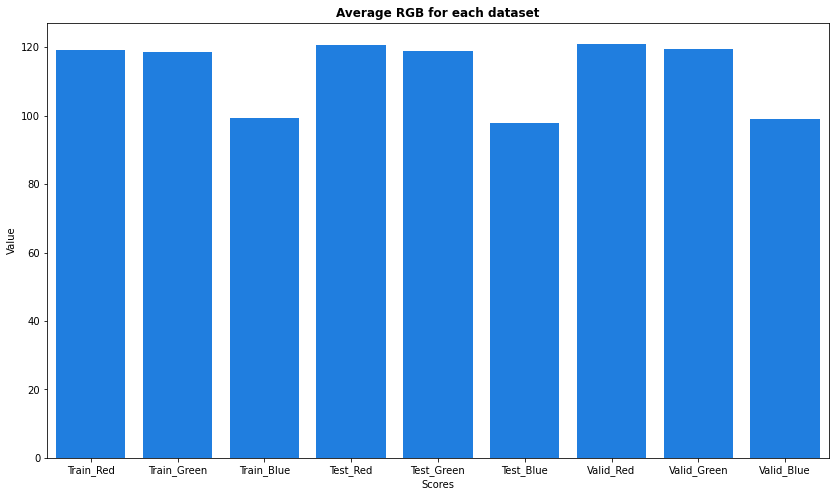

In [28]:
tidy = rgb_df.melt(id_vars='Species', var_name='Scores').rename(columns=str.title)
fig, ax = plt.subplots(figsize=(14, 8))

sns.barplot(x='Scores', y='Value', data=tidy, ax=ax, color='#007dff', ci=None)



plt.title('Average RGB for each dataset', weight='bold')
plt.show()

While this was to be expected we can see there is not a significant deviation from the RGB channels in our datasets while we could've guessed this outcome but now we know for sure when making our model perphaps we won't have to worry model prediction inaccuracy due to RGB.

## Prepare the Data

### Since the images are large, we need to resize and reduce the amount of pixel so we do not fall into a memory bottleneck, and kernel crash. We will also transform our rgb colored images to grayscale for later analysis. In my case I needed to reduce the images by a factor of 4 as 112 pixel size still led to overload of my GPU memory. I am running RTX 2080 8GB. 

### DO NOT RUN load the files below of train_norm

In [25]:
#DO NOT run load the files as this is a timely process.
train_resize = []
gs_train = []

for i in range(0, len(images['train'])):
    img = images['train'][i]
    new_img = cv2.resize(img, dsize=(56,56), interpolation=cv2.INTER_CUBIC)
    train_resize.append(new_img)
    
    gs_img = color.rgb2gray(new_img)
    gs_train.append(gs_img)

train_resize = np.array(train_resize)
gs_train = np.array(gs_train)

In [26]:
test_resize = []
gs_test = []

for i in range(0, len(images['test'])):
    img = images['test'][i]
    new_img = cv2.resize(img, dsize=(56,56), interpolation=cv2.INTER_CUBIC)
    test_resize.append(new_img)

    gs_img = color.rgb2gray(new_img)
    gs_test.append(gs_img)

test_resize = np.array(test_resize)
gs_test = np.array(gs_test)

In [27]:
valid_resize = []
gs_valid = []

for i in range(0, len(images['valid'])):
    img = images['valid'][i]
    new_img = cv2.resize(img, dsize=(56,56), interpolation=cv2.INTER_CUBIC)
    valid_resize.append(new_img)

    gs_img = color.rgb2gray(new_img)
    gs_valid.append(gs_img)    

valid_resize = np.array(valid_resize)
gs_valid = np.array(gs_valid)

#### Quick note originally when I was attempting to normalize my data I'd assumed that simply dividing by the max value onto the whole numpy array would suffice but after i did further digging I got different results, as dividing the whole array by 255 which was the max pixel value it return EXTREMELY similar values to taking the array and subtracting the minimum value then dividing the array by the MAX_VAL by the MIN_VAL

In [28]:
train_min = train_resize.min(axis=(1, 2), keepdims=True)
train_max = train_resize.max(axis=(1, 2), keepdims=True)

train_norm = (train_resize - train_min)/(train_max - train_min)

In [29]:
test_min = test_resize.min(axis=(1, 2), keepdims=True)
test_max = test_resize.max(axis=(1, 2), keepdims=True)

test_norm = (test_resize - test_min)/(test_max - test_min)

In [30]:
valid_min = valid_resize.min(axis=(1, 2), keepdims=True)
valid_max = valid_resize.max(axis=(1, 2), keepdims=True)

valid_norm = (valid_resize - valid_min)/(valid_max - valid_min)

#### Let's look at the new images from our reduced pixel size

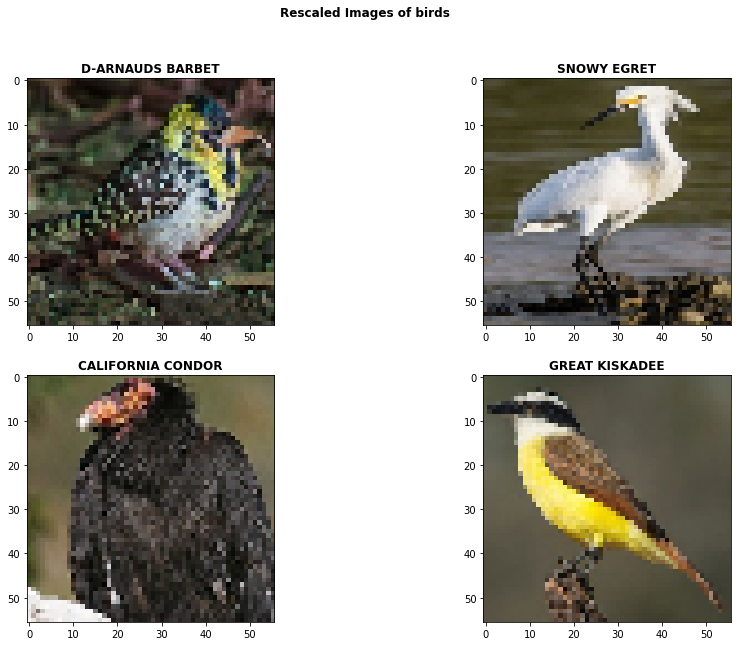

In [33]:
fig = plt.figure(figsize=(15,10))

row = 2
col = 2
fig.suptitle("Rescaled Images of birds", weight='bold')
plt.title
for i in range(1,5):
    img = random.randint(0, len(train_resize))
    ax = fig.add_subplot(row, col, i)
    ax.set_title(labels["train"][img], fontdict={"fontweight": 700})
    ax.imshow(train_resize[img])
    
    

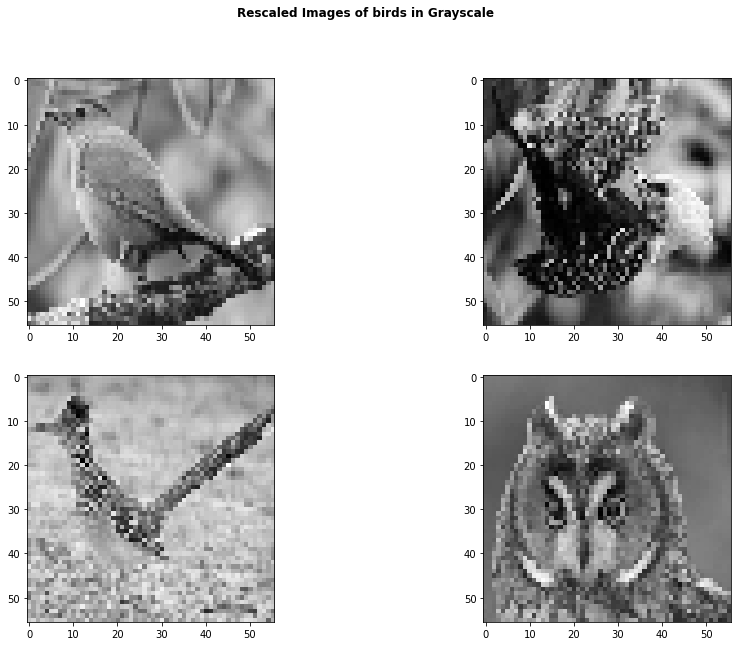

In [34]:
fig = plt.figure(figsize=(15,10))

row = 2
col = 2
fig.suptitle("Rescaled Images of birds in Grayscale", weight='bold')
plt.title
for i in range(1,5):
    img = random.randint(0, len(train_resize))
    ax = fig.add_subplot(row, col, i)
    ax.imshow(gs_train[img], cmap='gray')
    
    

In [31]:
# We also need to normalize the data we want to rescale the pixel values from the range of 0-255 to 0-1 which is preferred 
# for neural network
print(train_resize.max())
# since the max pixel in this case the ratio will be 1/255 

datagen = ImageDataGenerator(rescale=1/255)

255


In [32]:
# prepare an iterators to normalize the images 0-255 to 0-1
train_iterator = datagen.flow(train_resize, label_cat["train"], batch_size=64)
test_iterator = datagen.flow(test_resize, label_cat["test"], batch_size=64)
valid_iterator = datagen.flow(valid_resize, label_cat["valid"], batch_size=64)
print('Batches train=%d, test=%d, valid=%d' % (len(train_iterator), len(test_iterator), len(valid_iterator)))

Batches train=719, test=25, valid=25


In [33]:
batchX, batchy = train_iterator.next()
print('Train Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))

batchX, batchy = test_iterator.next()
print('Test Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))

batchX, batchy = valid_iterator.next()
print('Valid Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))

Train Batch shape=(64, 56, 56, 3), min=0.000, max=1.000
Test Batch shape=(64, 56, 56, 3), min=0.000, max=1.000
Valid Batch shape=(64, 56, 56, 3), min=0.000, max=1.000


#### We need to encode our labels that can be easily digestible for our models, so we will use LabelEncoder and keras categorical to transform once we encode our classes of birds. 

In [9]:
# We need to encode the labels from strings to categories, so we can use it with our model

encoder = LabelEncoder().fit(labels['train'])

In [10]:
label_cat = labels
label_cat["train"] = encoder.transform(labels["train"])
label_cat["test"] = encoder.transform(labels["test"])
label_cat["valid"] = encoder.transform(labels["valid"])

In [11]:
# Now to categories
from tensorflow.keras.utils import to_categorical

label_cat["train"] = to_categorical(label_cat["train"])
label_cat["test"] = to_categorical(label_cat["test"])
label_cat["valid"] = to_categorical(label_cat["valid"])


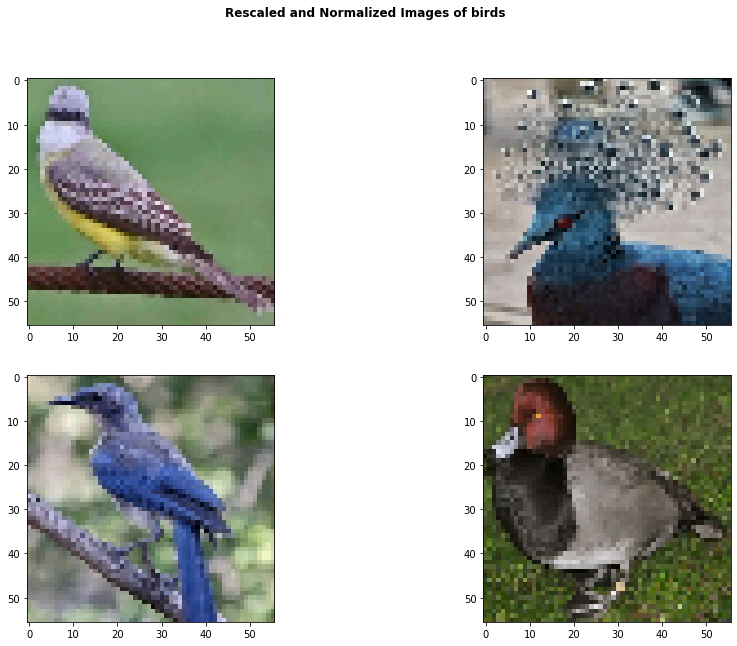

In [41]:
fig = plt.figure(figsize=(15,10))

row = 2
col = 2
fig.suptitle("Rescaled and Normalized Images of birds", weight='bold')
for i in range(1,5):
    img = random.randint(0, len(train_iterator.next()[0]))
    ax = fig.add_subplot(row, col, i)
    ax.imshow(train_iterator.next()[0][img])

#### Save Img and Label data and Loading Data 

In [30]:
X_train_dict = {'data':train_norm, 'label':label_cat['train']}
X_test_dict = {'data':test_norm, 'label':label_cat['test']}
X_valid_dict = {'data':valid_norm, 'label':label_cat['valid']}

In [40]:
np.save('X_train_file.npy', X_train_dict)
np.save('X_test_file.npy', X_test_dict)
np.save('X_valid_file.npy', X_valid_dict)

In [2]:
X_train_file = np.load('X_train_file.npy', allow_pickle=True)
X_test_file = np.load('X_test_file.npy', allow_pickle=True)
X_valid_file = np.load('X_valid_file.npy', allow_pickle=True)


X_train = X_train_file.item()['data']
y_train = X_train_file.item()['label'] 
X_test = X_test_file.item()['data']
y_test = X_test_file.item()['label'] 
X_valid = X_valid_file.item()['data']
y_valid = X_valid_file.item()['label'] 

In [49]:
print('X_train shape:'+str(X_train.shape), 'y_train shape:'+str(y_train.shape))
print('X_test shape:'+str(X_test.shape), 'y_test shape:'+str(y_test.shape))
print('X_valid shape:'+str(X_valid.shape), 'y_valid shape:'+str(y_valid.shape))

X_train shape:(45980, 56, 56, 3) y_train shape:(45980, 315)
X_test shape:(1575, 56, 56, 3) y_test shape:(1575, 315)
X_valid shape:(1575, 56, 56, 3) y_valid shape:(1575, 315)


### Base Model 

Let's start by creating a basic model withouth any CNN or MaxPooling to see how our model performs 

In [50]:
basic_model = Sequential()
basic_model.add(Flatten()) #What this does is take our multi-dimensional array or tensor into a single dimension
basic_model.add(Dense(32, activation='relu')) # This is the essential part of a neural network and what dense
# is doing is adding a layer to the network. Dense implements the following operation output = activation(dot(input, kernel) + bias) 
# where activation is the element-wise activation function passed as the activation argument, 
# kernel is a weights matrix created by the layer, and bias is a bias vector created by the layer.
# In our case we use the 'relu' activation function which is a piecewise linear function that will output the input directly if it is positive, otherwise, it will output zero
basic_model.add(Dense(64, activation='relu'))

basic_model.add(Dense(315, activation='softmax')) 
# The softmax is a output activation function which predicts a multinomial probability distribution.
# It is used in most cases to classific multi-class labels like in our case where we have 315 different species

basic_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# compile is just a function which defines our loss function, the optimizer and the metrics.\

basic_model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))
# epoch is essentially the number of times you go through the training set in more accurate definition
# it is an arbitrary cutoff, generally defined as "one pass over the entire dataset", used to separate training into distinct phases, 
# which is useful for logging and periodic evaluation.
_, acc = basic_model.evaluate(X_test, y_test, verbose=1)

print('Test Accuracy: %.3f' % (acc * 100))

Epoch 1/5
1437/1437 [==============================] - 6s 3ms/step - loss: 5.7500 - accuracy: 0.0047 - val_loss: 5.7577 - val_accuracy: 0.0032
Epoch 2/5
1437/1437 [==============================] - 4s 3ms/step - loss: 5.7437 - accuracy: 0.0053 - val_loss: 5.7612 - val_accuracy: 0.0032
Epoch 3/5
1437/1437 [==============================] - 4s 3ms/step - loss: 5.7427 - accuracy: 0.0053 - val_loss: 5.7611 - val_accuracy: 0.0032
Epoch 4/5
1437/1437 [==============================] - 4s 3ms/step - loss: 5.7424 - accuracy: 0.0054 - val_loss: 5.7623 - val_accuracy: 0.0032
Epoch 5/5
50/50 [==============================] - 0s 2ms/step - loss: 5.7607 - accuracy: 0.0032
Test Accuracy: 0.317


So this model got less than 1% accuracy which is horrible  but given how little effort and tuning we did to our neural network I'd say it suffice for demonstration purposes. In our next model we will add Convolutional Neural Network(CNN), and Max pooling. 

In [64]:
cnn_model = Sequential()
cnn_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(56, 56, 3)))
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Flatten())
cnn_model.add(Dense(1024, activation='relu'))
cnn_model.add(Dense(315, activation='softmax'))
# compile model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 56, 56, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 28, 28, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 7, 7, 128)       

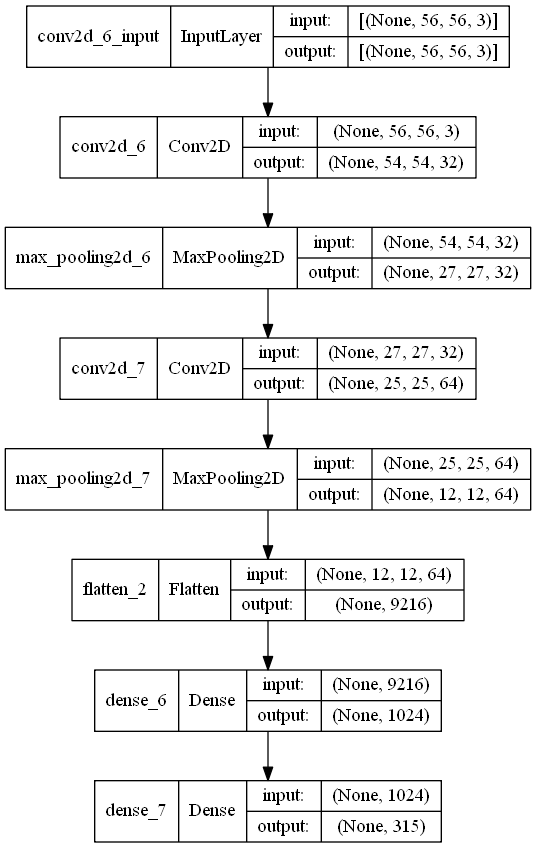

In [65]:
plot_model(cnn_model, to_file='basic_cnn_plot.png', show_shapes=True, show_layer_names=True)

In [10]:
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# fit model with generator
cnn_model_hist = cnn_model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))
# evaluate model
_, acc = cnn_model.evaluate(X_test, y_test, verbose=1)
print('Test Accuracy: %.3f' % (acc * 100))

Epoch 1/10
1437/1437 [==============================] - 9s 6ms/step - loss: 3.7565 - accuracy: 0.2358 - val_loss: 2.1849 - val_accuracy: 0.4933
Epoch 2/10
1437/1437 [==============================] - 8s 6ms/step - loss: 1.9304 - accuracy: 0.5533 - val_loss: 1.5492 - val_accuracy: 0.6146
Epoch 3/10
1437/1437 [==============================] - 9s 6ms/step - loss: 0.9460 - accuracy: 0.7572 - val_loss: 1.5536 - val_accuracy: 0.6267
Epoch 4/10
1437/1437 [==============================] - 9s 6ms/step - loss: 0.3324 - accuracy: 0.9099 - val_loss: 1.9167 - val_accuracy: 0.6095
Epoch 5/10
1437/1437 [==============================] - 9s 6ms/step - loss: 0.1844 - accuracy: 0.9478 - val_loss: 2.3419 - val_accuracy: 0.6038
Epoch 6/10
1437/1437 [==============================] - 8s 6ms/step - loss: 0.1495 - accuracy: 0.9579 - val_loss: 2.3750 - val_accuracy: 0.6178
Epoch 7/10
1437/1437 [==============================] - 9s 6ms/step - loss: 0.1258 - accuracy: 0.9634 - val_loss: 2.8305 - val_accuracy:

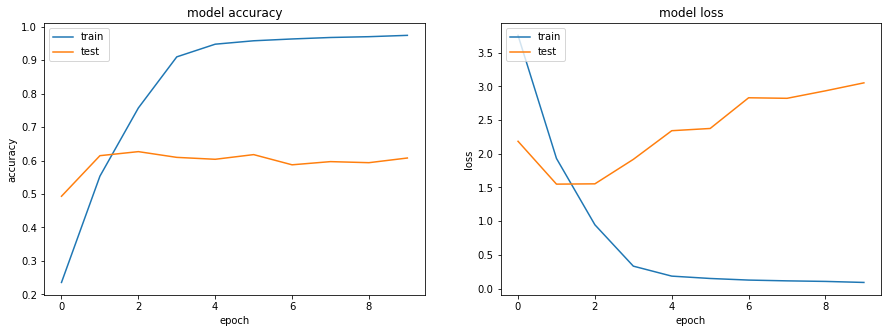

In [11]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(cnn_model_hist.history['accuracy'])
ax[0].plot(cnn_model_hist.history['val_accuracy'])
ax[0].set_title('model accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'test'], loc='upper left')


ax[1].plot(cnn_model_hist.history['loss'])
ax[1].plot(cnn_model_hist.history['val_loss'])
ax[1].set_title('model loss')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'test'], loc='upper left')
plt.show()

#### This is will be our BASELINE now we will begin tuning and changing our model to gain better results

Oh wow that's much better, adding MaxPooling and Con2d max a significant difference we went up to a 50% not what we're looking for but significant jump.

Now before we continue further into tuning our Neural Network Model let's see how grayscale images turn out so just like the steps we took for our RGB images we will repeat but for our grayscale images 

In [12]:
gs_model = Sequential()
gs_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(56, 56, 3)))
gs_model.add(MaxPooling2D((2, 2)))
gs_model.add(Conv2D(64, (3, 3), activation='relu'))
gs_model.add(MaxPooling2D((2, 2)))
gs_model.add(Flatten())
gs_model.add(Dense(1024, activation='relu'))
gs_model.add(Dense(315, activation='softmax'))
# compile model
gs_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 54, 54, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 27, 27, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 25, 25, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 9216)              0         
                                                                 
 dense_4 (Dense)             (None, 1024)             

In [147]:
gs_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# fit model with generator
gs_model_hist = gs_model.fit(gs_train, label_cat['train'],  epochs=100, validation_data = (gs_test, label_cat['test']))
# evaluate model
_, gs_acc = gs_model.evaluate(gs_test, label_cat['test'],  verbose=0)
print('Test Accuracy: %.3f' % (gs_acc * 100))

Epoch 1/100
1437/1437 [==============================] - 7s 5ms/step - loss: 5.2719 - accuracy: 0.0332 - val_loss: 4.5243 - val_accuracy: 0.0990
Epoch 2/100
1437/1437 [==============================] - 6s 5ms/step - loss: 4.3511 - accuracy: 0.1271 - val_loss: 3.9323 - val_accuracy: 0.1829
Epoch 3/100
1437/1437 [==============================] - 6s 4ms/step - loss: 3.9173 - accuracy: 0.1868 - val_loss: 3.6625 - val_accuracy: 0.2114
Epoch 4/100
1437/1437 [==============================] - 6s 4ms/step - loss: 3.6827 - accuracy: 0.2241 - val_loss: 3.4563 - val_accuracy: 0.2387
Epoch 5/100
1437/1437 [==============================] - 6s 4ms/step - loss: 3.5169 - accuracy: 0.2460 - val_loss: 3.3426 - val_accuracy: 0.2603
Epoch 6/100
1437/1437 [==============================] - 6s 4ms/step - loss: 3.3885 - accuracy: 0.2666 - val_loss: 3.2585 - val_accuracy: 0.2743
Epoch 7/100
1437/1437 [==============================] - 6s 4ms/step - loss: 3.2690 - accuracy: 0.2862 - val_loss: 3.2016 - val_ac

Epoch 57/100
1437/1437 [==============================] - 6s 4ms/step - loss: 1.2374 - accuracy: 0.6627 - val_loss: 6.7525 - val_accuracy: 0.2457
Epoch 58/100
1437/1437 [==============================] - 6s 4ms/step - loss: 1.2277 - accuracy: 0.6665 - val_loss: 6.8432 - val_accuracy: 0.2413
Epoch 59/100
1437/1437 [==============================] - 6s 4ms/step - loss: 1.2132 - accuracy: 0.6688 - val_loss: 6.9886 - val_accuracy: 0.2432
Epoch 60/100
1437/1437 [==============================] - 6s 4ms/step - loss: 1.1984 - accuracy: 0.6735 - val_loss: 7.1906 - val_accuracy: 0.2413
Epoch 61/100
1437/1437 [==============================] - 6s 4ms/step - loss: 1.1836 - accuracy: 0.6766 - val_loss: 7.3865 - val_accuracy: 0.2324
Epoch 62/100
1437/1437 [==============================] - 6s 4ms/step - loss: 1.1679 - accuracy: 0.6799 - val_loss: 7.3661 - val_accuracy: 0.2317
Epoch 63/100
1437/1437 [==============================] - 6s 4ms/step - loss: 1.1427 - accuracy: 0.6854 - val_loss: 7.5370 -

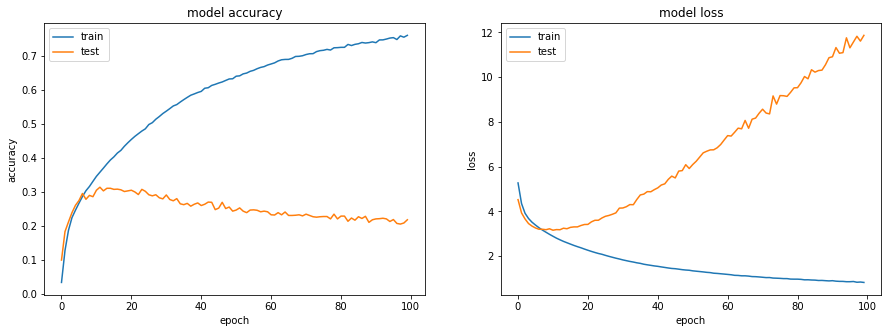

In [148]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(gs_model_hist.history['accuracy'])
ax[0].plot(gs_model_hist.history['val_accuracy'])
ax[0].set_title('model accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'test'], loc='upper left')


ax[1].plot(gs_model_hist.history['loss'])
ax[1].plot(gs_model_hist.history['val_loss'])
ax[1].set_title('model loss')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'test'], loc='upper left')
plt.show()

Okay, we can see as we train more and more our model does a poor job of predicting birds in grayscale, not only that our model is quite low intially as our max accuracy reachs 30% which is 25% less than our RGB prediction. We see that our model does better predictions with RGB dataset, naively this is to be expected as with color there is more data. We will continue with our RGB dataset. 

In [47]:
# data_augmentation = keras.Sequential(
#     [
#         layers.RandomFlip("horizontal"),
#         layers.RandomRotation(0.1),
#     ]
# )

Here we will dicuss everything that went into our model above. Many of the definitions here are from Keras Website.

    - Sequential: Sequential is a model in Keras which allows to create models layer by layer, according ot Keras it is a model                   with linear stack of layers. 
    - Conv2D: This creates a convolutional kernal which is convolved with layer input to create a tensor of outputs
        - Filters: Integer, the dimensionality of the output space (i.e. the number of output filters in the convolution).
        - Kernel_size: An integer or tuple/list of 2 integers, specifying the height and width of the 2D convolution window.Can                        be a single integer to specify the same value for all spatial dimensions.
        - Strides: An integer or tuple/list of 2 integers, specifying the strides of the convolution along the height and                          width. Can be a single integer to specify the same value for all spatial dimensions.
    - MaxPool2D: The maxpooling layer will reduce the size of each feature map by a factor of 2, reducing value of the pixels                    in the feature maps. Max pooling is said to allow for extraction of the sharpest features of a image and it is                  also faster to compute than convolutions. 
    - Flatten: Flatten takes all a N X N dimentional feature map and turns it into a FLAT 1 * (NxN) for example: 3x3 into 1x9  
    - Dense: Dense is the essential neural network layer, this decides the number of neurons in a layer and it receives all its              input from the previous layer. 
    - Dropout: Dropout is utilized to prevent overfitting of a neural netowrk, it works by randomly setting the neurons that                  make up the hidden layers to 0 at each update of a training phase. 
    - Optimizer: Optimizers are essentially methods used to change the weights and learning rate of your model to avoid                          reduction in losses.
    - Loss function: This is our value which the model attemps to minimize during its training.
    - Metric: This is a metric of evaluation to see how well our model does, a method to judge the performance of our model. 

Now we will tackle the problem with our model overfitting, we will utlize callbacks to implement early stopping, patience, ReduceLROnPlateau, factor and monitor which is the metric used to activate these methods.

    - Callbacks is a type of object in TensorFlow and Keras allows users to monitor the performance in metrics at certain points of a training run and execute actions depending on the performances based on the metric values.
    - EarlyStopping is part of callbacks where it allows the model to stop training when our metric stops improving.
    - ReduceLROnPlateau is a callback to reduce the learning rate when a metric has stopped improving.
    - Monitor is the metric that is used to determine when to activate these methods, in our case its validation accuracy loss for early stopping and validation model loss on Reducing learning rate on plateau
    - Patience is the number of epochs with no improvement after which training will be stopped.
    - Factor is the amount the learning rate will be reduced by.

In [17]:
import keras_tuner as kt
from keras_tuner.tuners import RandomSearch, Hyperband, BayesianOptimization 
from keras_tuner.engine.hyperparameters import HyperParameters

This is my best attempt at Hyper-Tuning my model. I am tuning the Conv2D with different number of input units ranging from 32 to 512 all multiples of 32, I had no reason. 

In [18]:
callback = [EarlyStopping(patience=2, monitor='val_accuracy', restore_best_weights=True),
            ReduceLROnPlateau(monitor = 'val_loss', patience = 1, factor=0.5, verbose=1)]

In [25]:
def random_model(hp):
    model = Sequential()
    #First Conv2D
    model.add(Conv2D(hp.Int('input_units', 
                            min_value=32, 
                            max_value=128, 
                            step=32), (3,3), input_shape=(56, 56, 3), padding='same', data_format='channels_last'))
    model.add(Activation('relu'))
    # First MaxPool
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same', data_format='channels_last'))
    # 2nd Conv2d
    for i in range(hp.Int('n_layers', 1, 4)):  # adding variation of layers.
        model.add(Conv2D(hp.Int(f'conv_{i}_units',
                                min_value=64,
                                max_value=224,
                                step=32), (3, 3), padding='same', data_format='channels_last'))
        model.add(Activation('relu'))  
        model.add(MaxPooling2D(pool_size=(2, 2), padding='same', data_format='channels_last'))
        
    
    model.add(Flatten())
    
    
    model.add(Dense(units=hp.Int('num_of_neurons',min_value=256,max_value=2048,step=256),
                                    activation='relu'))
    model.add(Dense(units=hp.Int('num_of_neurons_2',min_value=256,max_value=2048,step=256),
                                    activation='relu'))
    
    model.add(Dropout(hp.Float('dropout',min_value=0.0, max_value=0.8,step=0.1,default=0.2)))
    model.add(Dense(315, activation='softmax'))
    
    
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=["accuracy"])

    return model

In [32]:
random_tuner = RandomSearch(
    random_model,
    objective='val_accuracy',
    max_trials=50,  # how many model variations to test?
    executions_per_trial=1,  # how many trials per variation? (same model could perform differently)
    seed  = 7,
    directory='Tuners',
    project_name='Random')

INFO:tensorflow:Reloading Oracle from existing project Tuners\Random\oracle.json
INFO:tensorflow:Reloading Tuner from Tuners\Random\tuner0.json


In [33]:
%%time
random_tuner.search(x=X_train,
             y=y_train,
             epochs=50,
             callbacks=callback, 
             validation_data=(X_test, y_test))


Search: Running Trial #52

Hyperparameter    |Value             |Best Value So Far 
input_units       |64                |64                
n_layers          |2                 |1                 
conv_0_units      |192               |224               
num_of_neurons    |64                |64                
num_of_neurons_2  |160               |160               
dropout           |0.6               |0.1               
conv_1_units      |128               |160               
conv_2_units      |96                |None              
conv_3_units      |96                |None              

Epoch 1/50
1437/1437 [==============================] - 12s 8ms/step - loss: 5.2409 - accuracy: 0.0266 - val_loss: 4.3979 - val_accuracy: 0.0965 - lr: 0.0010
Epoch 2/50
 154/1437 [==>...........................] - ETA: 10s - loss: 4.6655 - accuracy: 0.0593

KeyboardInterrupt: 

In [7]:
random_tuner.results_summary()

Results summary
Results in Tuners\Random
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
input_units: 64
n_layers: 1
conv_0_units: 224
num_of_neurons: 64
num_of_neurons_2: 160
dropout: 0.1
conv_1_units: 160
Score: 0.7301587462425232
Trial summary
Hyperparameters:
input_units: 64
n_layers: 2
conv_0_units: 160
num_of_neurons: 96
num_of_neurons_2: 224
dropout: 0.1
conv_1_units: 192
conv_2_units: 160
conv_3_units: 128
Score: 0.7117460370063782
Trial summary
Hyperparameters:
input_units: 128
n_layers: 1
conv_0_units: 224
num_of_neurons: 128
num_of_neurons_2: 192
dropout: 0.30000000000000004
conv_1_units: 192
Score: 0.709841251373291
Trial summary
Hyperparameters:
input_units: 96
n_layers: 2
conv_0_units: 128
num_of_neurons: 96
num_of_neurons_2: 160
dropout: 0.0
conv_1_units: 224
conv_2_units: 224
conv_3_units: 224
Score: 0.7079365253448486
Trial summary
Hyperparameters:
input_units: 32
n_layers: 2
conv_0_units: 224
num_of_neurons: 96
num

In [45]:
def tuner_model(hp):
    model = Sequential()
    #First Conv2D
    model.add(Conv2D(hp.Int('input_units', 
                            min_value=32, 
                            max_value=128, 
                            step=32), (3,3), input_shape=(56, 56, 3), padding='same', data_format='channels_last'))
    model.add(Activation('relu'))
    # First MaxPool
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same', data_format='channels_last'))
    # N number of Conv2d
    for i in range(hp.Int('n_layers', 1, 4)):  # adding variation of layers.
        model.add(Conv2D(hp.Int(f'conv_{i}_units',
                                min_value=64,
                                max_value=512,
                                step=32), (3, 3), padding='same', data_format='channels_last'))
        model.add(Activation('relu'))    
        model.add(MaxPooling2D(pool_size=(2, 2), padding='same', data_format='channels_last'))
   
    
    model.add(Flatten())
    
    model.add(Dense(units=hp.Int('num_of_neurons',min_value=32,max_value=128,step=32),
                                    activation='relu'))
    model.add(Dense(units=hp.Int('num_of_neurons_2',min_value=64,max_value=256,step=32),
                                    activation='relu'))
    model.add(Dropout(hp.Float('dropout',min_value=0.0, max_value=0.8,step=0.05,default=0.1)))
    model.add(Dense(315, activation='softmax'))
    
    
    
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics="accuracy")

    return model

We've been using RandomSearch Tuner for most of our hyper-tuning but I realized a lot of time is wasted training bad 'parameters' since RandomSearch has no bias towards the parameters and hence the name the parameters are random so instead we will use hyperband, which avoids this major problem in random search. Hyperband will randomly sample the parameters but instead of running full max epochs on them they will initialize run few epochs to test out what type of results it is getting. Depending on the highest results it will then do a re-run of the parameters which yielded the best results and run the full epoch then.   

In [9]:
callbackh = [EarlyStopping(patience=2, monitor='val_accuracy', restore_best_weights=True),
            ReduceLROnPlateau(monitor = 'val_loss', patience = 1, factor=0.5, verbose=1)]

hyper_tuner = Hyperband(
    tuner_model,
    objective='val_accuracy',
    max_epochs=50,  
    hyperband_iterations=1,  # how many trials per variation? (same model could perform differently)
    seed  = 7,
    directory='Tuners',
    project_name='Hyperband')

INFO:tensorflow:Reloading Oracle from existing project Tuners\Hyperband\oracle.json
INFO:tensorflow:Reloading Tuner from Tuners\Hyperband\tuner0.json


In [11]:
hyper_tuner.search(x=X_train,
             y=y_train,
             epochs=30,
             callbacks=callbackh, 
             validation_data=(X_test, y_test))

Trial 31 Complete [00h 00m 44s]
val_accuracy: 0.0031746032182127237

Best val_accuracy So Far: 0.6901587247848511
Total elapsed time: 00h 28m 49s
INFO:tensorflow:Oracle triggered exit


In [12]:
hyper_tuner.results_summary()

Results summary
Results in Tuners\Hyperband
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
input_units: 96
n_layers: 2
conv_0_units: 224
num_of_neurons: 96
num_of_neurons_2: 160
dropout: 0.0
conv_1_units: 512
conv_2_units: 480
conv_3_units: 480
tuner/epochs: 25
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.6901587247848511
Trial summary
Hyperparameters:
input_units: 32
n_layers: 2
conv_0_units: 480
num_of_neurons: 96
num_of_neurons_2: 160
dropout: 0.0
conv_1_units: 160
conv_2_units: 480
conv_3_units: 416
tuner/epochs: 25
tuner/initial_epoch: 9
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: fefce4c3332c128728646d134e4753f0
Score: 0.6838095188140869
Trial summary
Hyperparameters:
input_units: 32
n_layers: 2
conv_0_units: 480
num_of_neurons: 96
num_of_neurons_2: 160
dropout: 0.0
conv_1_units: 160
conv_2_units: 480
conv_3_units: 416
tuner/epochs: 9
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.68000

While Hyperband is more efficient at getting rid of bad parameters it is still choosing at random, so I switch to BayesianOptimization(BO). BO address the random selection problem of both RandomSearch and Hyperband and selects first few parameters randomly, then depending on the performance on of those hyperparameters it select the next best hyperparameters. Using the performances of the previous hyperparameters which were used BO set the next hyperparameters based on past historical performance and this continues till the tuner reaches optimal hyperparameters or exhausts maximum number of trials allowed.

In [46]:
callbackb = [EarlyStopping(patience=2, monitor='val_accuracy', restore_best_weights=True),
            ReduceLROnPlateau(monitor = 'val_loss', patience = 1, factor=0.5, verbose=1)]

baye_tuner = BayesianOptimization(
    tuner_model,
    objective='val_accuracy',
    max_trials=50,  # how many model variations to test?
    seed = 7,
    directory='Tuners',
    project_name='BayeTuner')

INFO:tensorflow:Reloading Oracle from existing project Tuners\BayeTuner\oracle.json
INFO:tensorflow:Reloading Tuner from Tuners\BayeTuner\tuner0.json


In [16]:
baye_tuner.search(x=X_train,
             y=y_train,
             epochs=50,
             callbacks=callbackb, 
             validation_data=(X_test, y_test))

Trial 41 Complete [00h 02m 34s]
val_accuracy: 0.6565079092979431

Best val_accuracy So Far: 0.7117460370063782
Total elapsed time: 01h 12m 34s

Search: Running Trial #42

Hyperparameter    |Value             |Best Value So Far 
input_units       |32                |32                
n_layers          |1                 |2                 
conv_0_units      |512               |160               
num_of_neurons    |64                |256               
num_of_neurons_2  |256               |256               
dropout           |0                 |0.45              
conv_1_units      |64                |512               
conv_2_units      |512               |64                
conv_3_units      |512               |64                

Epoch 1/50
1437/1437 [==============================] - 14s 9ms/step - loss: 4.5425 - accuracy: 0.0957 - val_loss: 3.3386 - val_accuracy: 0.2406 - lr: 0.0010
Epoch 2/50
1437/1437 [==============================] - 14s 10ms/step - loss: 3.0375 - accuracy: 0.3

KeyboardInterrupt: 

In [47]:
baye_tuner.results_summary()

Results summary
Results in Tuners\BayeTuner
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
input_units: 32
n_layers: 2
conv_0_units: 160
num_of_neurons: 256
num_of_neurons_2: 256
dropout: 0.45
conv_1_units: 512
conv_2_units: 64
conv_3_units: 64
Score: 0.7117460370063782
Trial summary
Hyperparameters:
input_units: 32
n_layers: 1
conv_0_units: 416
num_of_neurons: 256
num_of_neurons_2: 256
dropout: 0.0
conv_1_units: 416
conv_2_units: 512
conv_3_units: 512
Score: 0.6920635104179382
Trial summary
Hyperparameters:
input_units: 128
n_layers: 1
conv_0_units: 512
num_of_neurons: 256
num_of_neurons_2: 256
dropout: 0.0
conv_1_units: 64
conv_2_units: 64
conv_3_units: 64
Score: 0.6787301301956177
Trial summary
Hyperparameters:
input_units: 32
n_layers: 1
conv_0_units: 512
num_of_neurons: 256
num_of_neurons_2: 256
dropout: 0.0
conv_1_units: 64
conv_2_units: 512
conv_3_units: 64
Score: 0.6736508011817932
Trial summary
Hyperparameters:
input_units

### Final Tuned Model

I learned Hypertuning is a daunting and time consuming task as it takes long computation time and sometimes the results might not garner much boost in performance. After some theory crafting and combining and more research I found the best parameters for our model would be below. There might have been a few changes here and there but for the most part this yielded the best results out of all models.

#### In order to upload my files on git I need to remove the Tuner historical data, I attempted to use .gitignore but for now I will remove them as they are not essential for this project. 

In [63]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(56, 56, 3), padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation="relu", padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation="relu", padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(2048, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(2048, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(315, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics="accuracy")



In [15]:
callback = [EarlyStopping(patience=3, monitor='val_accuracy', restore_best_weights=True),
            ReduceLROnPlateau(monitor = 'val_loss', patience = 1, factor=0.5, verbose=1)]

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 56, 56, 32)        896       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 28, 28, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 128)       73856     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 4, 4, 128)       

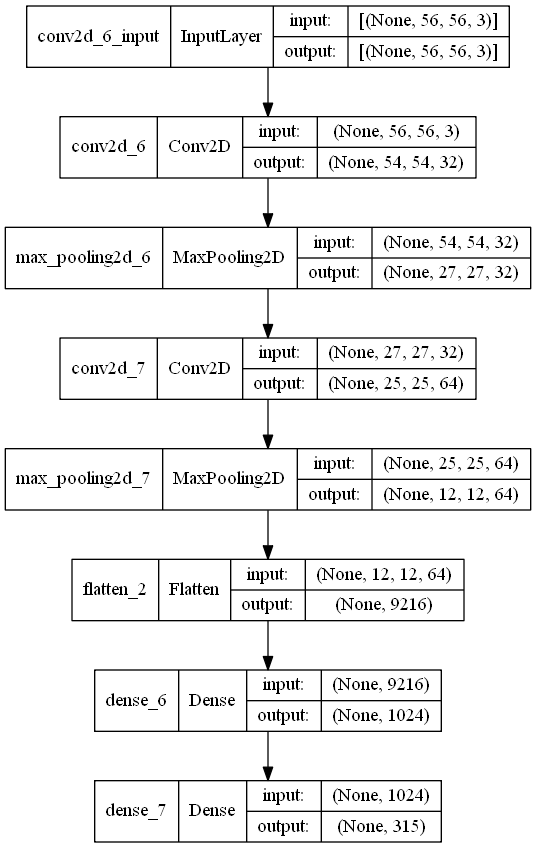

In [66]:
plot_model(cnn_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [19]:
callback = [EarlyStopping(patience=3, monitor='val_accuracy', restore_best_weights=True),
            ReduceLROnPlateau(monitor = 'val_loss', patience = 1, factor=0.5, verbose=1)]

model_hist = model.fit(X_train, y_train, callbacks=callback, epochs=100, validation_data=(X_test, y_test))

_, acc = model.evaluate(X_test, y_test, verbose=1)
print('Test Accuracy: %.3f' % (acc * 100))

Epoch 1/100
1437/1437 [==============================] - 11s 7ms/step - loss: 5.0144 - accuracy: 0.0461 - val_loss: 3.8492 - val_accuracy: 0.1511 - lr: 0.0010
Epoch 2/100
1437/1437 [==============================] - 10s 7ms/step - loss: 3.6342 - accuracy: 0.2089 - val_loss: 2.6279 - val_accuracy: 0.3841 - lr: 0.0010
Epoch 3/100
1437/1437 [==============================] - ETA: 0s - loss: 2.8109 - accuracy: 0.35 - 10s 7ms/step - loss: 2.8108 - accuracy: 0.3580 - val_loss: 2.0350 - val_accuracy: 0.4933 - lr: 0.0010
Epoch 4/100
1437/1437 [==============================] - 10s 7ms/step - loss: 2.2658 - accuracy: 0.4625 - val_loss: 1.6744 - val_accuracy: 0.5956 - lr: 0.0010
Epoch 5/100
1437/1437 [==============================] - 10s 7ms/step - loss: 1.8757 - accuracy: 0.5409 - val_loss: 1.4816 - val_accuracy: 0.6241 - lr: 0.0010
Epoch 6/100
1437/1437 [==============================] - 10s 7ms/step - loss: 1.5695 - accuracy: 0.6021 - val_loss: 1.4179 - val_accuracy: 0.6451 - lr: 0.0010
Epoc

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 56, 56, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 128)       73856     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 4, 4, 128)       

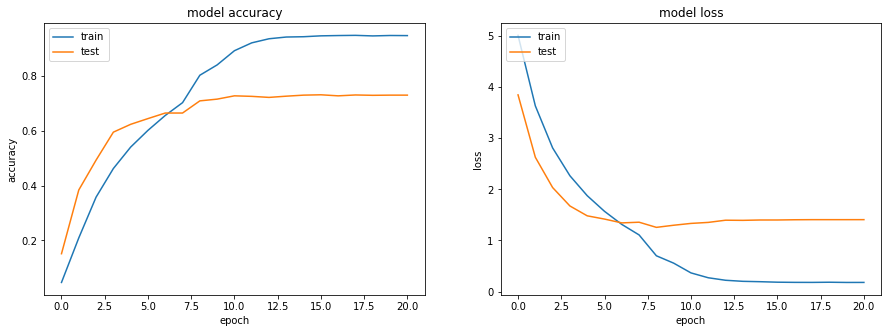

In [21]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(model_hist.history['accuracy'])
ax[0].plot(model_hist.history['val_accuracy'])
ax[0].set_title('model accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'test'], loc='upper left')


ax[1].plot(model_hist.history['loss'])
ax[1].plot(model_hist.history['val_loss'])
ax[1].set_title('model loss')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'test'], loc='upper left')
plt.show()

Now this is much more ideal, as we don't see a decline in performance as epochs increase, and we have avoided overfitting. We have also increased overall accuracy due to a more complex neural network. Now let's dig deep into hyperparameter tuning our model we will be using Keras build-in Keras Tuner

Rather further fine-tuning the model, it is safe to say our neural network is near its optimal accuracy, perphaps it can get to 75-80% but the time and computational cost of acheiving such a model would not be most optimal. An alternative solution is using large pre-trained models to train on your dataset. 

In [ ]:
#Due to tensorflow workload this hogs up my dedicated GPU memory and even though a model completes execution it continues to hold
# the GPU memory hostage so doing this after sessions allows my GPU to free up.
from numba import cuda

cuda.select_device(0)
cuda.close()